In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [30]:


def download_patents(params: dict, output_file: str, max_count: int):
    if not isinstance(params, dict):
        raise TypeError("params must be a dictionary")

    all_results = []  # List to store all the results
    total_count = 0  # Counter for the number of results fetched

    try:
        params["start"] = 0  # Initialize start parameter
        params["rows"] = 100  # Number of results per page

        while total_count < max_count:
            response = requests.get(
                "https://developer.uspto.gov/ibd-api/v1/application/publications", params, verify=False
            )
            result = response.json()
            
            # Get the current page of results
            results = result.get('results', [])
            
            # If no results, break out of the loop
            if not results:
                break
            
            # Append the current page of results to the list
            all_results.extend(results)
            
            # Update the total count
            total_count += len(results)
            
            # Check if the maximum count has been reached
            if total_count >= max_count:
                all_results = all_results[:max_count]  # Trim the list to max_count if necessary
                break

            # Update start parameter for the next page
            params["start"] += params["rows"]

        # Create the formatted output dictionary
        formatted_output = {"results": []}
        
        for item in all_results:
            formatted_item = {
                "inventionSubjectMatterCategory": item.get("inventionSubjectMatterCategory"),
                "patentApplicationNumber": item.get("patentApplicationNumber"),
                "filingDate": item.get("filingDate"),
                "mainCPCSymbolText": item.get("mainCPCSymbolText"),
                "furtherCPCSymbolArrayText": item.get("furtherCPCSymbolArrayText"),
                "inventorNameArrayText": item.get("inventorNameArrayText", []),
                "abstractText": item.get("abstractText", []),
                "assigneeEntityName": item.get("assigneeEntityName"),
                "assigneePostalAddressText": item.get("assigneePostalAddressText"),
                "inventionTitle": item.get("inventionTitle"),
                "filelocationURI": item.get("filelocationURI"),
                "archiveURI": item.get("archiveURI"),
                "claimText": item.get("claimText", []),
                "descriptionText": item.get("descriptionText", [])
            }
            formatted_output["results"].append(formatted_item)

        # Save formatted output to a JSON file
        with open(output_file, 'w') as f:
            import json
            json.dump(formatted_output, f, indent=4)

        print(f"Data saved to {output_file}.")

    except requests.exceptions.RequestException as e:
        print(f"Error fetching patents: {e}")

if __name__ == "__main__":
    params = {
        'start': 0,
        'rows': 100  # Fetch 100 records per page
    }
    download_patents(params, "patents_data.json", max_count=500)




c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.uspto.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.uspto.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'developer.uspto.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-

Data saved to patents_data.json.


In [4]:

df = pd.read_json("filtered_patents_data_20240915_162508.json")

# If the 'results' column contains nested dictionaries, we can normalize it
df = pd.json_normalize(df['results'])

# Display the first few rows of the normalized DataFrame
df.head()





,inventionSubjectMatterCategory,patentApplicationNumber,filingDate,mainCPCSymbolText,furtherCPCSymbolArrayText,inventorNameArrayText,abstractText,assigneeEntityName,assigneePostalAddressText,inventionTitle,filelocationURI,archiveURI,claimText,descriptionText,publicationDate,publicationDocumentIdentifier
0,utility,US13027052,02-14-2011,None,None,"[Powell Michael Charlton, Stokes Leslie James]",[The present invention provides a hand-utility...,None,None,HAND UTILITY INTERFACE,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A hand-utility interface for use in protec...,[The present invention relates to a hand-utili...,01-05-2012,US20120000001A1
1,utility,US12803617,07-01-2010,None,None,None,"[This invention, titled “Thumb-eez”, are a cel...",None,None,Thumb-eez,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. Thumb-eez allow more precise typing on min...,[Not ApplicableNot ApplicableNot ApplicableThi...,01-05-2012,US20120000002A1
2,utility,US13231432,09-13-2011,None,None,[Matthews Kevin L.],[A garment assembly includes a garment and a s...,CABELA'S INC.,"Sidney, US",GARMENT ASSEMBLY WITH DEPLOYABLE SEAT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A garment assembly comprising:a garment;a ...,[This application is a continuation of and cla...,01-05-2012,US20120000003A1
3,utility,US13256180,03-15-2010,None,None,None,[Exemplary embodiments of a quick release garm...,THF Innovation Pty Ltd.,"Victoria, AU",QUICK RELEASE GARMENT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[121-. (canceled)22. A quick release garment ...,[This application is a U.S. National Stage app...,01-05-2012,US20120000004A1
4,utility,US13159551,06-14-2011,None,None,"[Kishihara Hidetoshi, Ii Yasuyuki]",[A glove with a coating layer of rubber contai...,SHOWA GLOVE CO.,"Himeji-shi, JP",GLOVE AND METHOD FOR PRODUCING THE SAME,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A glove provided with a coating layer of r...,[1. Field of the InventionThe present inventio...,01-05-2012,US20120000005A1


### Pre-processing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   inventionSubjectMatterCategory  100 non-null    object
 1   patentApplicationNumber         100 non-null    object
 2   filingDate                      100 non-null    object
 3   mainCPCSymbolText               0 non-null      object
 4   furtherCPCSymbolArrayText       0 non-null      object
 5   inventorNameArrayText           80 non-null     object
 6   abstractText                    100 non-null    object
 7   assigneeEntityName              47 non-null     object
 8   assigneePostalAddressText       47 non-null     object
 9   inventionTitle                  100 non-null    object
 10  filelocationURI                 100 non-null    object
 11  archiveURI                      100 non-null    object
 12  claimText                       100 non-null    obj

In [6]:
df.drop(["mainCPCSymbolText", "furtherCPCSymbolArrayText"], axis=1).head()

,inventionSubjectMatterCategory,patentApplicationNumber,filingDate,inventorNameArrayText,abstractText,assigneeEntityName,assigneePostalAddressText,inventionTitle,filelocationURI,archiveURI,claimText,descriptionText,publicationDate,publicationDocumentIdentifier
0,utility,US13027052,02-14-2011,"[Powell Michael Charlton, Stokes Leslie James]",[The present invention provides a hand-utility...,None,None,HAND UTILITY INTERFACE,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A hand-utility interface for use in protec...,[The present invention relates to a hand-utili...,01-05-2012,US20120000001A1
1,utility,US12803617,07-01-2010,None,"[This invention, titled “Thumb-eez”, are a cel...",None,None,Thumb-eez,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. Thumb-eez allow more precise typing on min...,[Not ApplicableNot ApplicableNot ApplicableThi...,01-05-2012,US20120000002A1
2,utility,US13231432,09-13-2011,[Matthews Kevin L.],[A garment assembly includes a garment and a s...,CABELA'S INC.,"Sidney, US",GARMENT ASSEMBLY WITH DEPLOYABLE SEAT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A garment assembly comprising:a garment;a ...,[This application is a continuation of and cla...,01-05-2012,US20120000003A1
3,utility,US13256180,03-15-2010,None,[Exemplary embodiments of a quick release garm...,THF Innovation Pty Ltd.,"Victoria, AU",QUICK RELEASE GARMENT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[121-. (canceled)22. A quick release garment ...,[This application is a U.S. National Stage app...,01-05-2012,US20120000004A1
4,utility,US13159551,06-14-2011,"[Kishihara Hidetoshi, Ii Yasuyuki]",[A glove with a coating layer of rubber contai...,SHOWA GLOVE CO.,"Himeji-shi, JP",GLOVE AND METHOD FOR PRODUCING THE SAME,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A glove provided with a coating layer of r...,[1. Field of the InventionThe present inventio...,01-05-2012,US20120000005A1


In [7]:
df["inventionSubjectMatterCategory"] = df["inventionSubjectMatterCategory"].astype("category")
df["publicationDate"] = pd.to_datetime(df["publicationDate"])
df["filingDate"]=pd.to_datetime(df["filingDate"])


### Data Analysis

inventionSubjectMatterCategory

In [8]:
df.groupby("inventionSubjectMatterCategory").size()

inventionSubjectMatterCategory
utility    100
dtype: int64

Filingdate & PublicationDate

In [9]:
df["filingDate"].describe()

count                    100
mean     2011-01-03 11:45:36
min      2006-09-29 00:00:00
25%      2010-06-30 00:00:00
50%      2011-06-08 12:00:00
75%      2011-08-09 06:00:00
max      2011-09-19 00:00:00
Name: filingDate, dtype: object

In [10]:
df["publicationDate"].describe()

count                    100
mean     2012-01-05 00:00:00
min      2012-01-05 00:00:00
25%      2012-01-05 00:00:00
50%      2012-01-05 00:00:00
75%      2012-01-05 00:00:00
max      2012-01-05 00:00:00
Name: publicationDate, dtype: object

In [11]:
# group both dates based on quarters

In [12]:
df["day_differential"]=df["publicationDate"]-df["filingDate"]

In [13]:
df["day_differential"].describe()

count                            100
mean               366 days 12:14:24
std      280 days 13:22:48.653526696
min                108 days 00:00:00
25%                148 days 18:00:00
50%                210 days 12:00:00
75%                554 days 00:00:00
max               1924 days 00:00:00
Name: day_differential, dtype: object

In [14]:
df['day_differential'] = df['day_differential'].dt.days
plt.boxplot(df["day_differential"])



NameError: name 'plt' is not defined

InventorNameArrayText

In [107]:
#count number of null values
df["inventorNameArrayText"].isnull().sum()

20

In [108]:
#data points are formatted in an array, need to extract first and group after
lst = []
for x in df["inventorNameArrayText"]:
    if x is not None:  # Check if x is not None
        for y in x:
            lst.append(y)
inventor=pd.DataFrame(lst)



In [109]:
a=inventor.count()
print("number of inventor overall:")
a

number of inventor overall:


0    177
dtype: int64

In [110]:
counter=inventor.groupby(inventor[0]).size().reset_index(name='count')
counter.head()

,0,count
0,ALMABEKOV Didar,1
1,Albrecht Timothy,1
2,Allott Mark T.,1
3,Anthony Anthony,1
4,Anthony David,1


In [111]:
#get repeater inventor
counter=inventor.groupby(inventor[0]).size().reset_index(name='count')
counter[counter["count"]!=1]

,0,count
54,Hall David R.,2


In [112]:
df.head()

,inventionSubjectMatterCategory,patentApplicationNumber,filingDate,mainCPCSymbolText,furtherCPCSymbolArrayText,inventorNameArrayText,abstractText,assigneeEntityName,assigneePostalAddressText,inventionTitle,filelocationURI,archiveURI,claimText,descriptionText,publicationDate,publicationDocumentIdentifier,day_differential
0,utility,US13027052,2011-02-14,None,None,"[Powell Michael Charlton, Stokes Leslie James]",[The present invention provides a hand-utility...,None,None,HAND UTILITY INTERFACE,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A hand-utility interface for use in protec...,[The present invention relates to a hand-utili...,2012-01-05,US20120000001A1,325
1,utility,US12803617,2010-07-01,None,None,None,"[This invention, titled “Thumb-eez”, are a cel...",None,None,Thumb-eez,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. Thumb-eez allow more precise typing on min...,[Not ApplicableNot ApplicableNot ApplicableThi...,2012-01-05,US20120000002A1,553
2,utility,US13231432,2011-09-13,None,None,[Matthews Kevin L.],[A garment assembly includes a garment and a s...,CABELA'S INC.,"Sidney, US",GARMENT ASSEMBLY WITH DEPLOYABLE SEAT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A garment assembly comprising:a garment;a ...,[This application is a continuation of and cla...,2012-01-05,US20120000003A1,114
3,utility,US13256180,2010-03-15,None,None,None,[Exemplary embodiments of a quick release garm...,THF Innovation Pty Ltd.,"Victoria, AU",QUICK RELEASE GARMENT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[121-. (canceled)22. A quick release garment ...,[This application is a U.S. National Stage app...,2012-01-05,US20120000004A1,661
4,utility,US13159551,2011-06-14,None,None,"[Kishihara Hidetoshi, Ii Yasuyuki]",[A glove with a coating layer of rubber contai...,SHOWA GLOVE CO.,"Himeji-shi, JP",GLOVE AND METHOD FOR PRODUCING THE SAME,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A glove provided with a coating layer of r...,[1. Field of the InventionThe present inventio...,2012-01-05,US20120000005A1,205


AssigneePostalAddressText

In [116]:
#count number of null values
df["assigneePostalAddressText"].isnull().sum()

53

In [120]:
import re
def get_country(address):
    pattern = re.compile(r'\b(?:[A-Z][a-z]*\s?)+$')
    if address is not None:
        match = pattern.search(address)
        if match:
            return match.group(0)
        return None

In [115]:
df.head()

,inventionSubjectMatterCategory,patentApplicationNumber,filingDate,mainCPCSymbolText,furtherCPCSymbolArrayText,inventorNameArrayText,abstractText,assigneeEntityName,assigneePostalAddressText,inventionTitle,filelocationURI,archiveURI,claimText,descriptionText,publicationDate,publicationDocumentIdentifier,day_differential
0,utility,US13027052,2011-02-14,None,None,"[Powell Michael Charlton, Stokes Leslie James]",[The present invention provides a hand-utility...,None,None,HAND UTILITY INTERFACE,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A hand-utility interface for use in protec...,[The present invention relates to a hand-utili...,2012-01-05,US20120000001A1,325
1,utility,US12803617,2010-07-01,None,None,None,"[This invention, titled “Thumb-eez”, are a cel...",None,None,Thumb-eez,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. Thumb-eez allow more precise typing on min...,[Not ApplicableNot ApplicableNot ApplicableThi...,2012-01-05,US20120000002A1,553
2,utility,US13231432,2011-09-13,None,None,[Matthews Kevin L.],[A garment assembly includes a garment and a s...,CABELA'S INC.,"Sidney, US",GARMENT ASSEMBLY WITH DEPLOYABLE SEAT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A garment assembly comprising:a garment;a ...,[This application is a continuation of and cla...,2012-01-05,US20120000003A1,114
3,utility,US13256180,2010-03-15,None,None,None,[Exemplary embodiments of a quick release garm...,THF Innovation Pty Ltd.,"Victoria, AU",QUICK RELEASE GARMENT,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[121-. (canceled)22. A quick release garment ...,[This application is a U.S. National Stage app...,2012-01-05,US20120000004A1,661
4,utility,US13159551,2011-06-14,None,None,"[Kishihara Hidetoshi, Ii Yasuyuki]",[A glove with a coating layer of rubber contai...,SHOWA GLOVE CO.,"Himeji-shi, JP",GLOVE AND METHOD FOR PRODUCING THE SAME,https://dh-opendata.s3.amazonaws.com/publicati...,https://bulkdata.uspto.gov/data/patent/applica...,[1. A glove provided with a coating layer of r...,[1. Field of the InventionThe present inventio...,2012-01-05,US20120000005A1,205


In [124]:
#classify based on country
df["country"]=df["assigneePostalAddressText"].apply(get_country)

<BarContainer object of 17 artists>

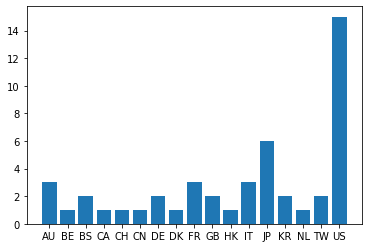

In [127]:
# Group by 'country' and count occurrences
country_counts = df.groupby('country').size().reset_index(name='count')
plt.bar(country_counts["country"], country_counts["count"])

DescriptionText & ClaimText

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
texts = pd.DataFrame({
    'title': df['inventionTitle'],  # Column for title
    'claim': df['claimText'],
    'desc': df["descriptionText"]
})

In [ ]:
def convert_text(lst_txt):
  return ("".join(lst_txt))

In [ ]:
texts["claim"]=texts["claim"].apply(convert_text)
texts["desc"]=texts["desc"].apply(convert_text)

In [ ]:
texts["claim"].isnull().sum()

In [ ]:
lemmatizer = WordNetLemmatizer()
def process_text(text):
    # Tokenize the text
    words = word_tokenize(text)

    # Initialize stopwords set
    stop_words = set(stopwords.words('english'))

    # Remove stopwords and non-alphabetic words
    filtered_words = [word for word in words if word.isalpha() and word.lower() not in stop_words]

    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]

    return lemmatized_words

In [ ]:
texts["lemma_desc"] = texts["desc"].apply(process_text)
texts["lemma_claim"] = texts["claim"].apply(process_text)

In [ ]:
#show similarity between desc, abstract, and claim
#get overlapping words used
s=set()
b=set()
for x in texts["lemma_claim"]:
  for y in x:
    s.add(y)
for a in texts["lemma_desc"]:
  for c in a:
    b.add(c)

result=s.intersection(b)
print(len(result))

In [ ]:
vectorizer = TfidfVectorizer(max_features=500)
texts["lemma_claim"]=texts["lemma_claim"].apply(lambda x: " ".join(x))
dtm = vectorizer.fit_transform(texts["lemma_claim"])
dtm_df1 = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
vectorizer = TfidfVectorizer(max_features=500)
texts["lemma_desc"]=texts["lemma_desc"].apply(lambda x: " ".join(x))
dtm1 = vectorizer.fit_transform(texts["lemma_desc"])
dtm_df2 = pd.DataFrame(dtm.toarray(), columns=vectorizer.get_feature_names_out())
print(dtm_df2)

In [ ]:
wc = WordCloud().generate(' '.join(texts["lemma_claim"]))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Claim Word Cloud")
plt.show()

In [ ]:
wc = WordCloud().generate(' '.join(texts["lemma_desc"]))
plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Description Text Word Cloud")
plt.show()